# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


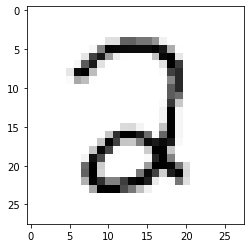

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2368
Training Accuracy: 0.7334, Testing Accuracy: 0.7142



Epoch 10, Loss 0.1247
Training Accuracy: 0.9069, Testing Accuracy: 0.9138



Epoch 20, Loss 0.0668
Training Accuracy: 0.9368, Testing Accuracy: 0.9466



Epoch 30, Loss 0.0488
Training Accuracy: 0.9497, Testing Accuracy: 0.9577



Epoch 40, Loss 0.0407
Training Accuracy: 0.9563, Testing Accuracy: 0.9652



Epoch 50, Loss 0.0361
Training Accuracy: 0.9599, Testing Accuracy: 0.9677



Epoch 60, Loss 0.0331
Training Accuracy: 0.9636, Testing Accuracy: 0.9718



Epoch 70, Loss 0.0309
Training Accuracy: 0.9659, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0293
Training Accuracy: 0.9674, Testing Accuracy: 0.9703



Epoch 90, Loss 0.028
Training Accuracy: 0.9688, Testing Accuracy: 0.9708



Epoch 100, Loss 0.027
Training Accuracy: 0.9702, Testing Accuracy: 0.9708



Epoch 110, Loss 0.0261
Training Accuracy: 0.9710, Testing Accuracy: 0.9708



Epoch 120, Loss 0.0253
Training Accuracy: 0.9715, Testing Accuracy: 0.9708



Epoch 130, Loss 0.0246
Training Accuracy: 0.9718, Testing Accuracy: 0.9723



Epoch 140, Loss 0.024
Training Accuracy: 0.9720, Testing Accuracy: 0.9713



Epoch 150, Loss 0.0234
Training Accuracy: 0.9727, Testing Accuracy: 0.9713



Epoch 160, Loss 0.0229
Training Accuracy: 0.9733, Testing Accuracy: 0.9728



Epoch 170, Loss 0.0224
Training Accuracy: 0.9740, Testing Accuracy: 0.9733



Epoch 180, Loss 0.022
Training Accuracy: 0.9746, Testing Accuracy: 0.9733



Epoch 190, Loss 0.0215
Training Accuracy: 0.9755, Testing Accuracy: 0.9723



Epoch 200, Loss 0.0211
Training Accuracy: 0.9760, Testing Accuracy: 0.9728



Epoch 210, Loss 0.0207
Training Accuracy: 0.9766, Testing Accuracy: 0.9723



Epoch 220, Loss 0.0204
Training Accuracy: 0.9770, Testing Accuracy: 0.9733



Epoch 230, Loss 0.02
Training Accuracy: 0.9776, Testing Accuracy: 0.9728



Epoch 240, Loss 0.0197
Training Accuracy: 0.9781, Testing Accuracy: 0.9728



0.017329366979284236

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2402
Training Accuracy: 0.6622, Testing Accuracy: 0.6683



Epoch 10, Loss 0.1074
Training Accuracy: 0.8963, Testing Accuracy: 0.9108



Epoch 20, Loss 0.0813
Training Accuracy: 0.9236, Testing Accuracy: 0.9340



Epoch 30, Loss 0.0694
Training Accuracy: 0.9349, Testing Accuracy: 0.9446



Epoch 40, Loss 0.0624
Training Accuracy: 0.9403, Testing Accuracy: 0.9461



Epoch 50, Loss 0.0576
Training Accuracy: 0.9445, Testing Accuracy: 0.9486



Epoch 60, Loss 0.0541
Training Accuracy: 0.9464, Testing Accuracy: 0.9526



Epoch 70, Loss 0.0515
Training Accuracy: 0.9479, Testing Accuracy: 0.9556



Epoch 80, Loss 0.0494
Training Accuracy: 0.9490, Testing Accuracy: 0.9572



Epoch 90, Loss 0.0477
Training Accuracy: 0.9508, Testing Accuracy: 0.9577



Epoch 100, Loss 0.0462
Training Accuracy: 0.9520, Testing Accuracy: 0.9592



Epoch 110, Loss 0.045
Training Accuracy: 0.9532, Testing Accuracy: 0.9602



Epoch 120, Loss 0.0439
Training Accuracy: 0.9539, Testing Accuracy: 0.9602



Epoch 130, Loss 0.043
Training Accuracy: 0.9553, Testing Accuracy: 0.9607



Epoch 140, Loss 0.0421
Training Accuracy: 0.9559, Testing Accuracy: 0.9607



Epoch 150, Loss 0.0414
Training Accuracy: 0.9562, Testing Accuracy: 0.9622



Epoch 160, Loss 0.0407
Training Accuracy: 0.9564, Testing Accuracy: 0.9627



Epoch 170, Loss 0.0401
Training Accuracy: 0.9572, Testing Accuracy: 0.9632



Epoch 180, Loss 0.0395
Training Accuracy: 0.9579, Testing Accuracy: 0.9637



Epoch 190, Loss 0.039
Training Accuracy: 0.9584, Testing Accuracy: 0.9647



Epoch 200, Loss 0.0385
Training Accuracy: 0.9591, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0381
Training Accuracy: 0.9594, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0377
Training Accuracy: 0.9598, Testing Accuracy: 0.9657



Epoch 230, Loss 0.0373
Training Accuracy: 0.9599, Testing Accuracy: 0.9657



Epoch 240, Loss 0.0369
Training Accuracy: 0.9601, Testing Accuracy: 0.9667



0.005766712876395387

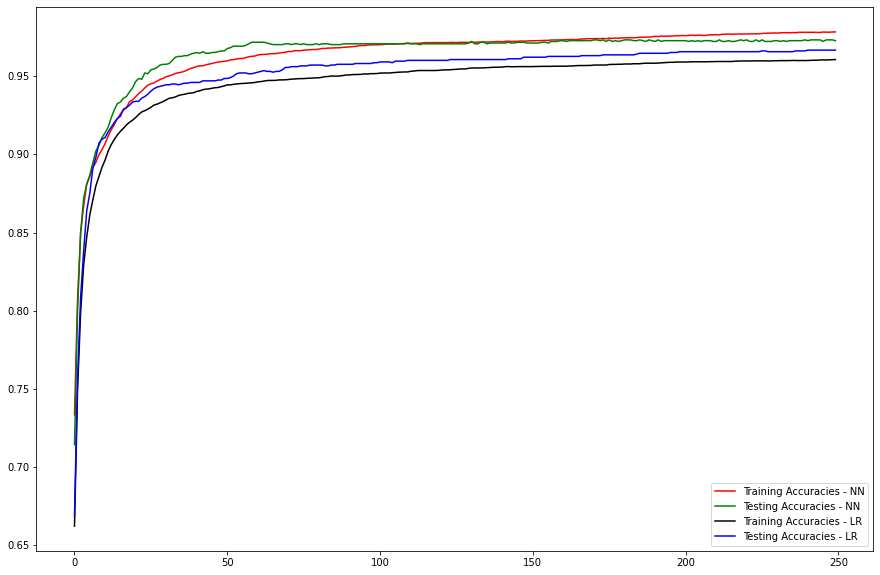

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

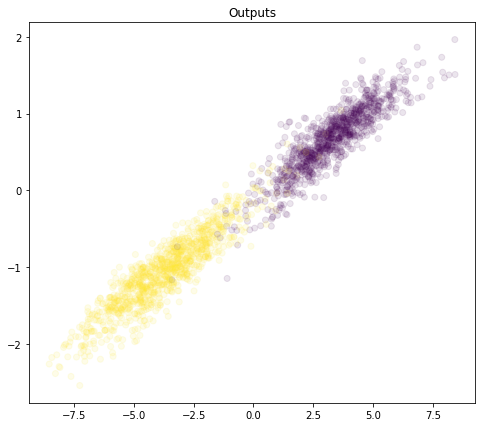

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

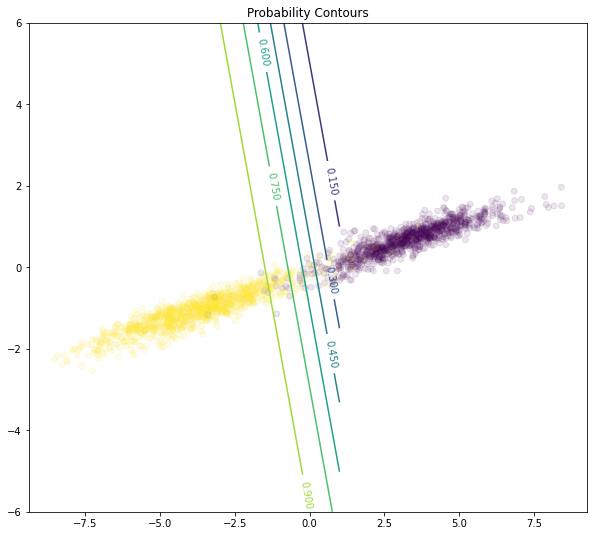

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );